In [73]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import LSTM, MaxPool1D, GlobalAveragePooling1D, Activation

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
file = open('/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [76]:
# 컬럼명
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [77]:
# 데이터프레임 생성
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [78]:
# 결측치 확인
df.isnull().sum()

,0
user,0
activity,0
time,0
x,0
y,0
z,0


In [79]:
# 라벨 값 확인
df['activity'].value_counts()

,count
activity,
Walking,137375
Jogging,129392
Upstairs,35137
Downstairs,33358
Sitting,4599
Standing,3555


In [80]:
# float로 타입 변환
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [81]:
activities = df['activity'].value_counts().index

In [82]:
# 문자를 숫자로 엔코딩
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [83]:
from sklearn import preprocessing

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [84]:
X = df[['x', 'y', 'z']]
y = df['ActivityEncoded']

In [85]:
Fs = 60
frame_size = Fs*4 # 240
hop_size = Fs*2 # 120

In [86]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3
    frames = []
    labels = []

    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['activity'][i: i + frame_size])[0]

        frames.append(np.vstack([x, y, z]).T)
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames)
    labels = np.asarray(labels)

    return frames, labels

In [87]:
# 서브젝트 와이즈
# 타입을 int로 변환
df['user'] = df['user'].astype(int)

# 1번~27번 사용자는 훈련용으로 사용
df_train = df[df['user'] <= 27]

# 28번~33번 사용자는 테스트용(검증용)으로 사용
df_test = df[df['user'] > 27]

In [88]:
# 정규화


min_X, max_X = df_train['x'].min(), df_train['x'].max()
min_Y, max_Y = df_train['y'].min(), df_train['y'].max()
min_Z, max_Z = df_train['z'].min(), df_train['z'].max()

# df_train을 정규화
df_train['x'] = (df_train['x'] - min_X) / (max_X - min_X)
df_train['y'] = (df_train['y'] - min_Y) / (max_Y - min_Y)
df_train['z'] = (df_train['z'] - min_Z) / (max_Z - min_Z)

# df_test도 정규화
df_test['x'] = (df_test['x'] - min_X) / (max_X - min_X)
df_test['y'] = (df_test['y'] - min_Y) / (max_Y - min_Y)
df_test['z'] = (df_test['z'] - min_Z) / (max_Z - min_Z)

/tmp/ipython-input-964121530.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['x'] = (df_train['x'] - min_X) / (max_X - min_X)
/tmp/ipython-input-964121530.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = (df_train['y'] - min_Y) / (max_Y - min_Y)
/tmp/ipython-input-964121530.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [89]:
# 분할된 훈련 데이터 프레임으로 훈련용 frames와 labels 생성
X_train, y_train = get_frames(df_train, frame_size, hop_size)

# 분할된 테스트 데이터 프레임으로 테스트용 frames와 labels 생성
X_test, y_test = get_frames(df_test, frame_size, hop_size)

# 데이터 형태 확인
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (1680, 240, 3)
X_test.shape: (1179, 240, 3)
y_train.shape: (1680,)
y_test.shape: (1179,)


In [90]:
# CNN-LSTM 모델
model_CNN_LSTM = Sequential()

# CNN 부분
model_CNN_LSTM.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                          padding='same', input_shape=(frame_size, 3)))
model_CNN_LSTM.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model_CNN_LSTM.add(MaxPooling1D(pool_size=2))


# LSTM 부분
model_CNN_LSTM.add(LSTM(32, return_sequences=False, activation='tanh'))


# 출력층
model_CNN_LSTM.add(Dropout(0.5))
model_CNN_LSTM.add(Dense(6, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
model_CNN_LSTM.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
model_CNN_LSTM.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 240, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 240, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,606 (100.02 KB)

 Trainable params: 25,606 (100.02 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# 모델 예측값과 결과값의 형태가 달라서 원핫 엔코딩 사용
from keras.utils import to_categorical

y_train_hot = to_categorical(y_train, num_classes=6)
y_test_hot = to_categorical(y_test, num_classes=6)

In [93]:
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_CNN_LSTM = model_CNN_LSTM.fit(X_train, y_train_hot, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.4047 - loss: 1.4734 - val_accuracy: 0.4643 - val_loss: 1.4464
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.4943 - loss: 1.2565 - val_accuracy: 0.4643 - val_loss: 1.4159
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6481 - loss: 0.9775 - val_accuracy: 0.5506 - val_loss: 1.3833
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.5762 - loss: 1.0838 - val_accuracy: 0.4792 - val_loss: 1.3871
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6673 - loss: 1.0235 - val_accuracy: 0.6756 - val_loss: 1.4929
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5973 - loss: 1.0528 - val_accuracy: 0.7530 - val_loss: 0.9917
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.6769 - loss: 0.9405 - val_accuracy: 0.7530 - val_loss: 1.3414
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7023 - loss: 0.9294 - val_accuracy: 0.4643 - 

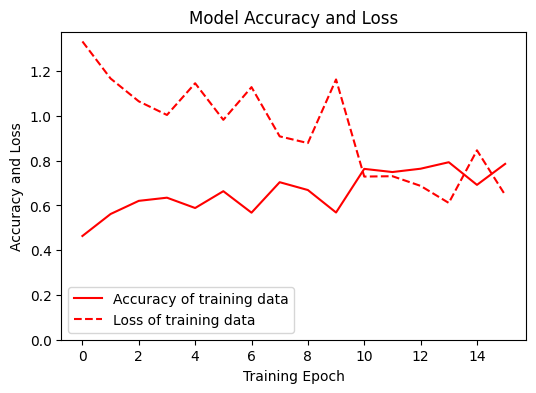

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.89      0.99      0.94       642
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00       160
           5       0.68      0.94      0.79       700

    accuracy                           0.77      1680
   macro avg       0.26      0.32      0.29      1680
weighted avg       0.62      0.77      0.69      1680



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 4))
plt.plot(history_CNN_LSTM.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history_CNN_LSTM.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model_CNN_LSTM.predict(X_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


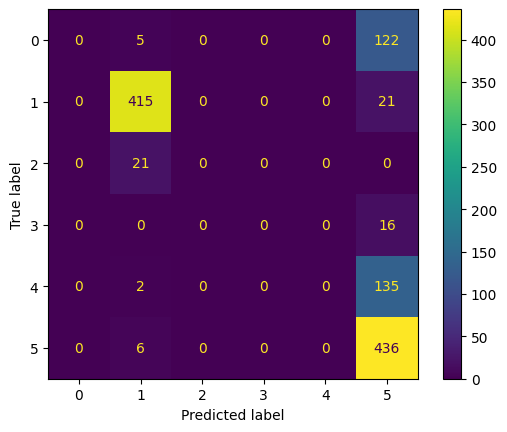

In [95]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

predictions = model_CNN_LSTM.predict(X_test)
predictions = np.argmax(predictions, axis=1)
# y_test_pred = np.argmax(y_test, axis=1) # Remove this line
cm = confusion_matrix(y_test, predictions) # Use y_test directly
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [96]:
from sklearn.metrics import classification_report

# y_test_pred is no longer needed here as y_test is used directly in the previous cell's confusion matrix
print(classification_report(y_test, predictions)) # Use y_test directly

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       127
           1       0.92      0.95      0.94       436
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00       137
           5       0.60      0.99      0.74       442

    accuracy                           0.72      1179
   macro avg       0.25      0.32      0.28      1179
weighted avg       0.57      0.72      0.63      1179



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
